## Heatmap using Plotly

Here I will be illustrating making heatmaps using Plotly. <br/> 
Plotly is available for both python and javascript. <br/>
I used this library extensively for my paper "PeTra: A Sparsely Supervised Memory Model for People Tracking" - https://www.aclweb.org/anthology/2020.acl-main.481.pdf 

In [28]:
import os
from os import path
import json
import numpy as np
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Load data 

In this figure we will be visualizing the run of a memory model which performs "OVERWRITE (OW)" & "COREF (CR)" operations (performed softly) upon seeing each token in the text. In this particular example the model has 4 memory cells. We will visualize the two operations for each cell separately with the cells stacked on top of each other. <br/>

In [29]:
data_file = "../data/heatmap_plotly.json"
data = json.loads(open(data_file).read())

text = data["text"]
overwrite = np.array(data["overwrite"]).T  # 4 x L
coref = np.array(data["coref"]).T  # 4 x L

num_cells = overwrite.shape[0]
print (overwrite.shape, coref.shape)  # (4, 80) for both - # of cells is 4 and text length is 80 

(4, 80) (4, 80)


### Heatmaps with Subplots sharing X-axis

In [30]:
def make_plot(num_cells, text, coref, overwrite):
    # Make subplots for 4 cells
    fig = make_subplots(rows=num_cells, cols=1, # Grid config
                        shared_xaxes=True,  # Shared X-axis
                        vertical_spacing=0.02, y_title=r'Memory Cells',)

    # Find the global max and global min so that the heatmaps use the same boundaries
    zmin = min(np.min(overwrite), np.min(coref))
    zmax = max(np.max(overwrite), np.max(coref))

    for i in range(num_cells):
        # Add the heatmap
        fig.append_trace(
            go.Heatmap(
                z=np.stack([coref[i, :], overwrite[i, :]]),
                zmin=zmin - 0.3, # Offsetting the zmin because otherwise the lowest values become white
                zmax=zmax, showscale=False,  
                colorscale='Blues'
            ),
            row=i+1, col=1,  # Plot identification
        )
        # Set Y-axis ticks
        fig.update_yaxes(row=i+1, ticktext=[r'CR', r'OW'], showticklabels=True, 
                         tickcolor='#000000', tickvals=[0, 1], ticks='outside')

    # Set X-axis ticks shared by all the subplots
    fig.update_xaxes(row=num_cells, col=1, ticktext=text, showticklabels=True, tickvals=list(range(len(text))), 
                     tickangle=300, tickfont={'family':'Open Sans', 'size': 12}, tickcolor='#000000')

    # Update the layout and save the figure
    fig.update_layout(height=250, width=1000, margin={'l': 60, 'r': 5, 't':5, 'b': 5})
    fig.show("jpg", height=250, width=1000)
    fig.write_image("../plots/heatmap_plotly.jpg")


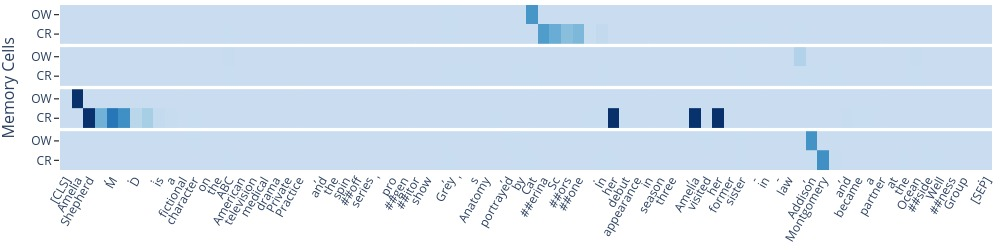

In [31]:
make_plot(num_cells, text, coref, overwrite)

### Too much text - Reduce text!
For most of the text nothing is happening in the memory. <br/>
We can remove those parts by ellipsis. 

In [32]:
# Skip the uninteresting portions of the text and the corresponding overwrite & coref vectors
def skip_data_op(skip_list, array):
    array_list = [array]
    cur_offset = 0
    for (start_point, end_point) in skip_list:
        last_item = np.array(array_list[-1])
        del array_list[-1]
        array_list.append(last_item[:, :start_point-cur_offset])
        array_list.append(last_item[:, end_point-cur_offset:])
        cur_offset = end_point
        
    return np.concatenate(array_list, axis=1)

def skip_text_fn(skip_list, text):
    text_list = [text]
    cur_offset = 0
    for (start_point, end_point) in skip_list:
        last_item = text_list[-1]
        del text_list[-1]
        a1 = last_item[:start_point-cur_offset]
        a1 = a1[:-1] + [a1[-1] + " ..."]
        text_list.append(a1)
        
        a2 = last_item[end_point-cur_offset:]
        a2 =  ["... " + a2[0]] + a2[1:]
        text_list.append(a2)
        
        cur_offset = end_point
        
    final_text = []
    for text_piece in text_list:
        final_text.extend(text_piece)
        
    return final_text


## Remove the uninteresting portions
skip_list = [(12, 38), (67, 75)]

overwrite = skip_data_op(skip_list, overwrite)
coref = skip_data_op(skip_list, coref)

text = skip_text_fn(skip_list, text)
print(overwrite.shape, coref.shape)  # Reduced text length

(4, 46) (4, 46)


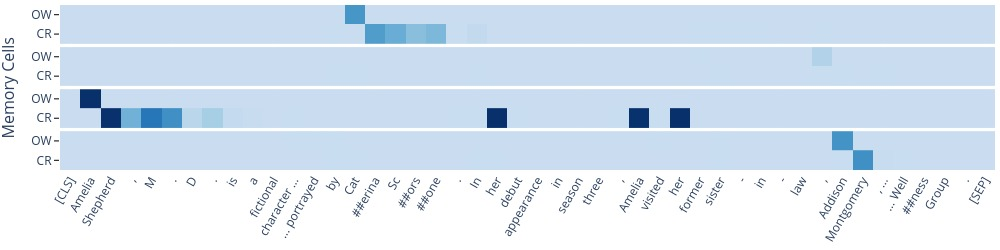

In [33]:
make_plot(num_cells, text, coref, overwrite)